# Maximum Likelihood Estimation of a multivariate Gaussian model

The goal of this notebook is to use PyTorch to implement Gradient-based MLE for a multivariate Gaussian model.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Single 2D Gaussian component

Let's generate a some data by sampling a multivariate Gaussian with an arbitrary covariance matrix:

In [2]:
rng = np.random.RandomState(42)
n_features = 2

mean = rng.randn(n_features)
mean

array([ 0.49671415, -0.1382643 ])

In [3]:
h = rng.randn(n_features, n_features)
Cov = h @ h.T
Cov

array([[ 2.73912039, -0.50825603],
       [-0.50825603,  0.10964792]])

In [4]:
np.linalg.cholesky(np.linalg.inv(Cov))

array([[ 1.61547341,  0.        ],
       [ 7.48827815,  3.01995037]])

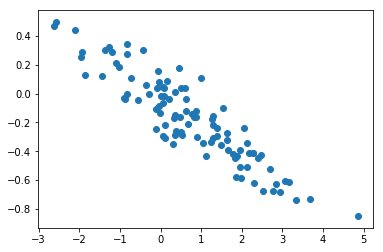

In [5]:
n_samples = 100
data = rng.multivariate_normal(mean, Cov, size=n_samples)
plt.scatter(data[:, 0], data[:, 1]);

Let's compute the MLE estimate from this data using the closed-form formula:

In [6]:
mu_mle = data.mean(axis=0)
mu_mle

array([ 0.70263098, -0.17305392])

In [7]:
Cov_mle = (data - mu_mle).T @ (data - mu_mle) / n_samples
Cov_mle

array([[ 2.0476404 , -0.38824024],
       [-0.38824024,  0.08873728]])

In [8]:
np.linalg.cholesky(np.linalg.inv(Cov_mle))

array([[ 1.69266713,  0.        ],
       [ 7.40569797,  3.356966  ]])

## Parametrisation of a positive definite matrix


Let's parametrize the precision matrix `P` (inverse of a covariance matrix `C`) as follows:

- `P` has Cholesky decomposition `H`
- `H` is a lower triangular with a positive diagonal
- the log of the diagonal entry is stored in a vector of parameters named `d`
- the off diagonal elements of `H` are stored in the matrix of parameters named `W`

In [9]:
import torch
from torch.autograd import Variable

mu = Variable(torch.zeros(n_features), requires_grad=True)
d = Variable(torch.ones(n_features), requires_grad=True)
W = Variable(torch.randn(n_features, n_features), requires_grad=True)
H = torch.diag(torch.exp(d)) + torch.tril(W, -1)
P = H @ H.transpose(1, 0)
P

Variable containing:
 7.3891  1.1539
 1.1539  7.5692
[torch.FloatTensor of size 2x2]

Let's check that H is the actual Cholesky decomposition of P:

In [10]:
H.data.numpy()

array([[ 2.71828175,  0.        ],
       [ 0.42448446,  2.71828175]], dtype=float32)

In [11]:
np.linalg.cholesky(P.data.numpy())

array([[ 2.71828175,  0.        ],
       [ 0.42448443,  2.71828175]], dtype=float32)

`P` is positive semi-definite by construction (product of a matrix `H` by its transposed).

Because of we take the `exp` of `d` to build the diagonal elements of `H`, the determinant of `H` and therefore `P` is stricly positive.

`P` is therefore is positive definite, whatever the values the parameters in `d` and `W`. Because the Cholesky decomposition exists for any symmetric positive-definite  matrix and is unique and `exp` is a bijection from $\mathbb{R}$ to $\mathbb{R}^+$, this parametrization of the manifold of positive definite matrices is bijective.

In [12]:
np.linalg.det(P.data.numpy())

54.598145

In [13]:
np.linalg.det(H.data.numpy()) ** 2

54.598144564972472

The determinant of `P` is cheap to compute from the `d` parameters directly:

In [14]:
torch.prod(torch.exp(d.data) ** 2)

54.59814456497247

Let's use the above function to define the log-likelihood of a Gaussian model:

In [15]:
from math import log


def loglik(X, mu, d, W):
    """Compute the average log-likelihood of samples
    
    X shape: (n_samples, n_features)
        data points
        
    mu: shape: (n_features,)
        parameters of the mean of the Gaussian.
    
    d: shape: (n_features,)
        parameters of the diagonal of the Cholesky factor of the
        precision matrix of the Gaussian.
        
    W: shape: (n_features, n_features)
        parameters of the off-diagonal of the Cholesky factor of the
        precision matrix of the Gaussian. The upper-diagonal elements
        are ignored.
    """
    H = torch.diag(torch.exp(d)) + torch.tril(W, -1)
    P = H @ H.transpose(1, 0)
    diff = X - mu
    quad_form = torch.sum(diff * (diff @ P), dim=1)
    return (-0.5 * log(2 * np.pi) + torch.sum(d) - 0.5 * quad_form)


def nll(X, mu, d, W):
    """Average negative log likelihood loss to minimize"""
    return -torch.mean(loglik(X, mu, d, W))

In [16]:
X = Variable(torch.FloatTensor(data))
loss = nll(X, mu, d, W)
loss

Variable containing:
 8.1689
[torch.FloatTensor of size 1]

In [17]:
loss.backward([torch.ones(1)])

In [18]:
mu.grad

Variable containing:
-4.9921
 0.4991
[torch.FloatTensor of size 2]

In [19]:
d.grad

Variable containing:
 17.1898
 -0.1230
[torch.FloatTensor of size 2]

In [20]:
W.grad

Variable containing:
 0.0000  0.0000
-1.3355  0.0000
[torch.FloatTensor of size 2x2]

In [21]:
H_mle = torch.FloatTensor(np.linalg.cholesky(np.linalg.inv(Cov_mle)))
d_mle = Variable(torch.log(torch.diag(H_mle)))
W_mle = Variable(torch.tril(H_mle, -1))
nll(X, Variable(torch.FloatTensor(mu_mle)), d_mle, W_mle)

Variable containing:
 0.1816
[torch.FloatTensor of size 1]

In [22]:
learning_rate = 1e-1
optimizer = torch.optim.Adam([mu, d, W], lr=learning_rate)
for t in range(2000):
    # Compute and print loss.
    loss = nll(X, mu, d, W)
    if t % 100 == 0:
        print(t, loss.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 8.168852806091309
100 0.30568256974220276
200 0.1895122528076172
300 0.1818172186613083
400 0.18178629875183105
500 0.1815975457429886
600 0.18159589171409607
700 0.1820509284734726
800 0.1815958470106125
900 0.18159770965576172
1000 0.18159615993499756
1100 0.18159539997577667
1200 0.18168118596076965
1300 0.181595116853714
1400 0.18159544467926025
1500 0.18160125613212585
1600 0.18159569799900055
1700 0.18159571290016174
1800 0.18160350620746613
1900 0.18159537017345428


In [23]:
mu_mle

array([ 0.70263098, -0.17305392])

In [24]:
mu

Variable containing:
 0.7026
-0.1731
[torch.FloatTensor of size 2]

In [25]:
d_mle

Variable containing:
 0.5263
 1.2110
[torch.FloatTensor of size 2]

In [26]:
d

Variable containing:
 0.5263
 1.2110
[torch.FloatTensor of size 2]

In [27]:
W * Variable(torch.tril(torch.ones(n_features, n_features), -1))

Variable containing:
-0.0000  0.0000
 7.4057  0.0000
[torch.FloatTensor of size 2x2]

In [28]:
W_mle

Variable containing:
 0.0000  0.0000
 7.4057  0.0000
[torch.FloatTensor of size 2x2]

## Mixture of 2D Gaussian components

Let's generate some ground truth Gaussian Mixture Model with 3 components.

In [29]:
rng = np.random.RandomState(42)
n_features = 2
n_components = 3

means = [rng.randn(n_features) * 8 for _ in range(n_components)]
means

[array([ 3.97371322, -1.10611441]),
 array([  5.1815083 ,  12.18423885]),
 array([-1.873227  , -1.87309566])]

In [30]:
covariances = []
for _ in range(n_components):
    h = rng.randn(n_features, n_features)
    covariances.append(h @ h.T)

Let's generate some data from the ground truth model:

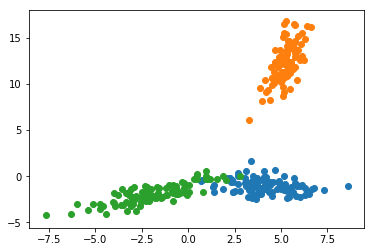

In [31]:
from sklearn.utils import shuffle

n_samples_per_component = 100

samples = []
component_ids = []

for i, mean, Cov in zip(range(n_components), means, covariances):
    data = rng.multivariate_normal(mean, Cov, size=n_samples_per_component)
    samples.append(data)
    component_ids.append(i * np.ones(n_samples_per_component, dtype=np.int32))
    plt.scatter(data[:, 0], data[:, 1])
    
data = np.vstack(samples)
component_ids = np.concatenate(component_ids)

data, component_ids = shuffle(data, component_ids, random_state=0)

There is no closed form formula for the MLE. Let's use the scikit-learn implementation of the EM algorithm instead:

In [32]:
from sklearn.mixture import GaussianMixture


gmm_em = GaussianMixture(n_components=3, random_state=0).fit(data)

Average loglikelihood of the data under the EM-MLE model:

In [33]:
gmm_em.score(data)

-3.9059040992134775

Let's find the MLE by gradient descent:

In [75]:
X = Variable(torch.FloatTensor(data))

softmax = torch.nn.Softmax()
weights = softmax(Variable(torch.ones(1, n_components))).view(n_components)
likelihoods = []
means = []
prec_diags = []
prec_off_diags = []
for i in range(n_components):
    mu = Variable(torch.zeros(n_features), requires_grad=True)
    means.append(mu)
    d = Variable(torch.ones(n_features), requires_grad=True)
    prec_diags.append(d)
    W = Variable(torch.randn(n_features, n_features), requires_grad=True)
    prec_off_diags.append(W)
    likelihoods.append(torch.exp(loglik(X, mu, d, W)))
    
likelihoods = torch.cat(likelihoods).view(n_components, -1)
torch.sum(weights.view(n_components, 1) * likelihoods, 1)


params = [weights]
params.extend(means)
params.extend(prec_diags)
params.extend(prec_off_diags)

torch.Size([3, 300])

In [43]:
weights

Variable containing:
 0.3333
 0.3333
 0.3333
[torch.FloatTensor of size 3]

In [55]:
likelihoods

AttributeError: 'list' object has no attribute 'size'